In [ ]:
pip install yfinance

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

In [21]:
trainData = yf.download("BTC-USD", start="2014-01-01", end="2021-09-01")
testData = yf.download("BTC-USD", start="2021-09-02")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


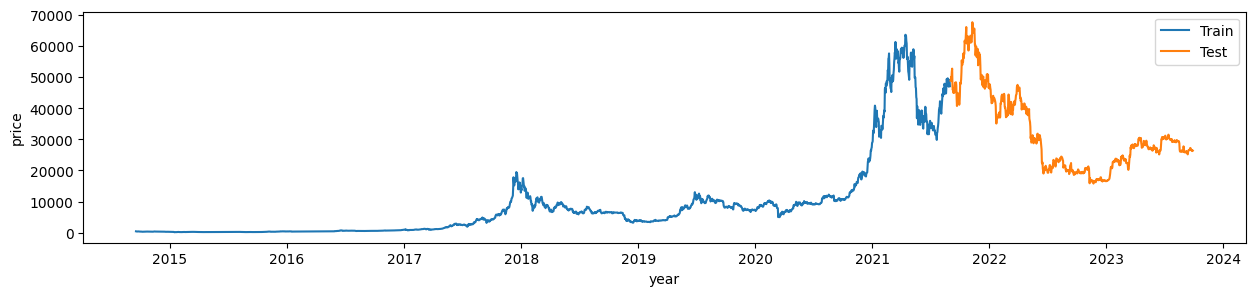

In [7]:
plt.figure(figsize=(15, 3))
plt.plot(trainData["Open"], label="Train")
plt.plot(testData["Open"], label="Test")
plt.xlabel('year')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [22]:
#normalization
trainData = trainData['Open'].values.reshape(-1, 1)
testData = testData['Open'].values.reshape(-1, 1)


scaler = MinMaxScaler()
scaler.fit(trainData)
trainData = scaler.fit_transform(trainData)
testData = scaler.fit_transform(testData)


print("Train shape:", trainData.shape)
print("Test shape:", testData.shape)

Train shape: (2541, 1)
Test shape: (757, 1)


In [23]:
# train and test set
x = 60
x_train = np.zeros((trainData.shape[0]-x, x, 1))
y_train = np.zeros((trainData.shape[0]-x,))
for i in range(x, trainData.shape[0]):
        temp = 0
        for j in range(i-x, i):
            x_train[i-x, temp, 0] = trainData[j, 0]
            temp += 1
        y_train[i-x] = trainData[i, 0]

temp_set = np.concatenate((trainData[trainData.shape[0]-x:], testData))
x_test = np.zeros((testData.shape[0], x, 1))
y_test = np.zeros((testData.shape[0],))
for i in range(testData.shape[0]):
    temp = 0
    for j in range(i, i+x):
        x_test[i, temp, 0] = temp_set[j, 0]
        temp += 1
    y_test[i] = temp_set[i+x, 0]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2481, 60, 1)
y_train shape: (2481,)
x_test shape: (757, 60, 1)
y_test shape: (757,)


In [24]:
#creating our model
model = Sequential([
    Input(shape=((x, 1))),
    LSTM(units=50, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])

model.compile(
    loss= MeanSquaredError(),
    optimizer=Adam(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [25]:
#train the model
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=100
)

Epoch 1/100
78/78 [==============================] - 21s 156ms/step - loss: 0.0054 - accuracy: 8.0613e-04 - val_loss: 0.0058 - val_accuracy: 0.0026
Epoch 2/100
78/78 [==============================] - 11s 140ms/step - loss: 0.0015 - accuracy: 8.0613e-04 - val_loss: 0.0044 - val_accuracy: 0.0026
Epoch 3/100
78/78 [==============================] - 11s 138ms/step - loss: 0.0014 - accuracy: 8.0613e-04 - val_loss: 0.0044 - val_accuracy: 0.0026
Epoch 4/100
78/78 [==============================] - 9s 122ms/step - loss: 0.0015 - accuracy: 8.0613e-04 - val_loss: 0.0035 - val_accuracy: 0.0026
Epoch 5/100
78/78 [==============================] - 11s 134ms/step - loss: 0.0011 - accuracy: 8.0613e-04 - val_loss: 0.0031 - val_accuracy: 0.0026
Epoch 6/100
78/78 [==============================] - 11s 138ms/step - loss: 0.0011 - accuracy: 8.0613e-04 - val_loss: 0.0042 - val_accuracy: 0.0026
Epoch 7/100
78/78 [==============================] - 11s 140ms/step - loss: 9.1084e-04 - accuracy: 8.0613e-04 - v

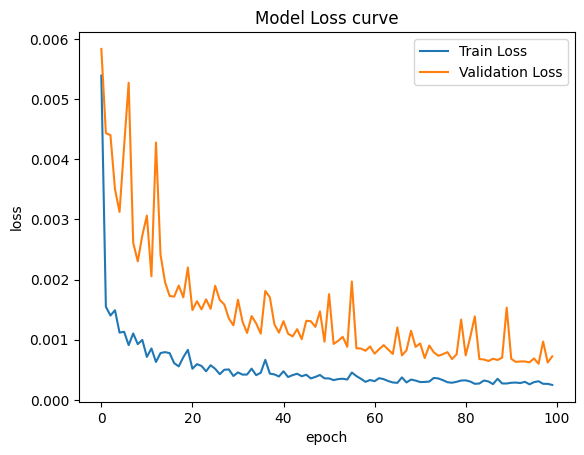

In [26]:
#plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Model Loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.savefig('LossCurve.png')
plt.show()

24/24 [==============================] - 1s 28ms/step


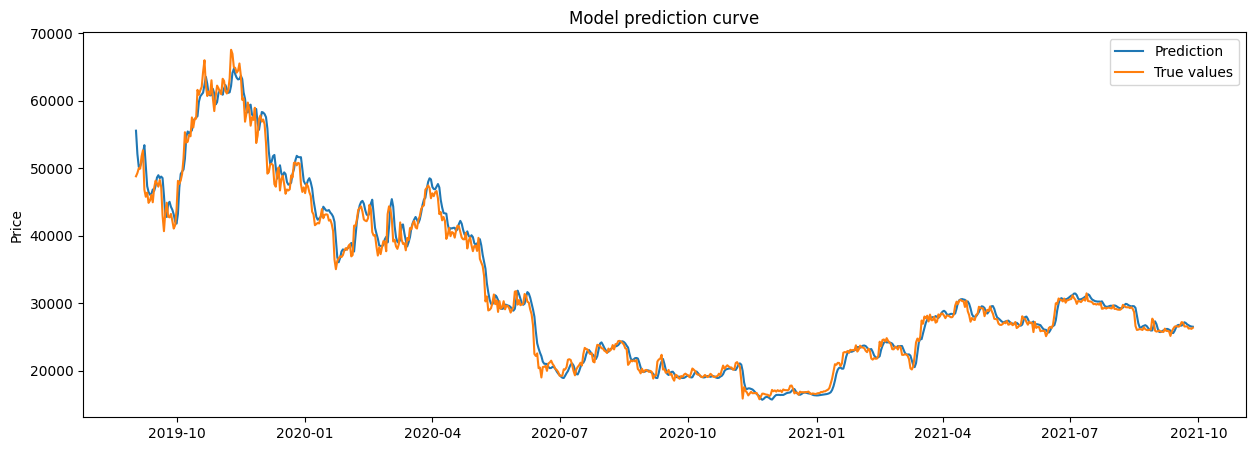

In [32]:
#prediction plot test
y_predict = np.squeeze(scaler.inverse_transform(model.predict(x_test)))
y_true = np.squeeze(scaler.inverse_transform([y_test]))

start_date = datetime(2019, 9, 2)
date_range = [start_date + timedelta(days=i) for i in range(len(x_test))]

plt.figure(figsize=(15, 5))
plt.plot(date_range, y_predict, label="Prediction")
plt.plot(date_range, y_true, label="True values")
plt.title('Model prediction curve')
plt.ylabel('Price')
plt.legend(loc="best")
plt.savefig('PredictionCurve.png')
plt.show()

In [40]:
date_range[-1] - timedelta(60)

datetime.datetime(2021, 7, 29, 0, 0)

1/1 [==============================] - 0s 32ms/step


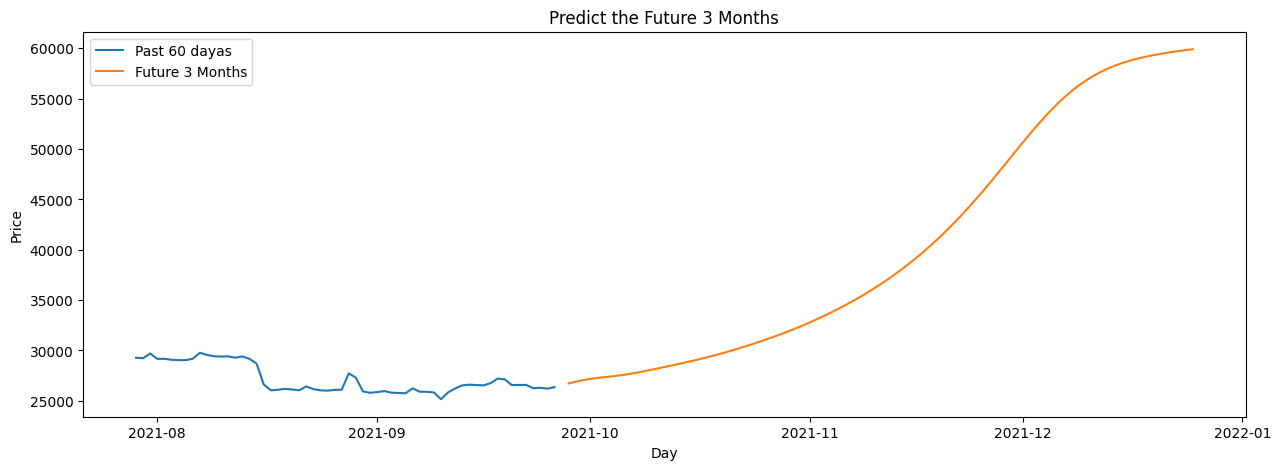

In [43]:
#predict the 3month future
future_time = 90
test_data = np.concatenate((testData[testData.shape[0]-x:], np.zeros((future_time, 1))))

for i in range(x, future_time + x):
    batch = np.expand_dims(test_data[i-x:i].T, axis=2)
    test_data[i] = np.squeeze(model.predict(batch))

test_data = scaler.inverse_transform(test_data)
past_prices = test_data[:x]
future_prices = test_data[x+1:]

start_date = date_range[-1] - timedelta(60)
date_range_past = [start_date + timedelta(days=i) for i in range(x)]

start_date = date_range[-1]
date_range_future = [start_date + timedelta(days=i) for i in range(1, future_time)]

plt.figure(figsize=(15, 5))
plt.plot(date_range_past, past_prices, label = "Past 60 dayas")
plt.plot(date_range_future, future_prices, label = "Future 3 Months")
plt.title("Predict the Future 3 Months")
plt.xlabel("Day")
plt.ylabel('Price')
plt.legend(loc = "best")
plt.savefig('FuturePredictionCurve.png')
plt.show()